In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class SpectralDecompositionPowerMethod:
    """
    Store the output vector in the object attribute self.components_ and the 
    associated eigenvalue in the object attribute self.singular_values_ 
    
    Why this code structure and attribute names? We are using the convention used by 
    the popular scikit-learn machine learning library:
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

    Parameters
        max_iter (int): maximum number of iterations to for the calculation
        tolerance (float): fractional change in solution to stop iteration early
        gamma (float): momentum parameter for the power method
        random_state (int): random seed for reproducibility
        store_intermediate_results (bool): whether to store the intermediate results as
            the power method iterates
        stored_eigenvalues (list): If store_intermediate_results is active, a list of 
            eigenvalues at each iteration
        stored_eigenvectors (list): If store_intermediate_results is active, a list of
            eigenvectors at each iteration
    
    """
    
    def __init__(self, 
        max_iter=1000, 
        tolerance=1e-5, 
        gamma=0.0,
        random_state=None, 
        store_intermediate_results=False
    ):
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.gamma = gamma
        np.random.seed(random_state)
        
        self.singular_values_ = None
        self.components_ = None
        
        self.store_intermediate_results = store_intermediate_results
        self.stored_eigenvalues = list()
        self.stored_eigenvectors = list()
        
    
    def fit(self, A):
        """
        Perform the power method with random initialization, and optionally store
        intermediate estimates of the eigenvalue and eigenvectors at each iteration.
        You can add an early stopping criterion based on the tolerance parameter.
        """
        
        w = np.random.random(len(A))
        pre_w = np.zeros(len(A))
        
        if self.store_intermediate_results: self.stored_eigenvectors.append(w)
        
        for i in range(self.max_iter):
            
            pre_w = np.copy(w)
            w = np.matmul(A, w)

            lam = np.dot(w, pre_w)/np.dot(pre_w,pre_w)
            w /= np.linalg.norm(w)
            pre_w /= np.linalg.norm(pre_w)
            
            w = w * (1 - self.gamma) + self.gamma*pre_w
             
            if self.store_intermediate_results:
                self.stored_eigenvectors.append(w) 
                self.stored_eigenvalues.append(lam)
                
            if np.linalg.norm(w - pre_w) < self.tolerance:
                break
                                
        self.singular_values_ = lam
        self.components_ = np.copy(w)
        

Power method solution: 0.053004449975268576
Numpy solution: 0.0530044373840963


Text(0, 0.5, 'Power method eigenvector')

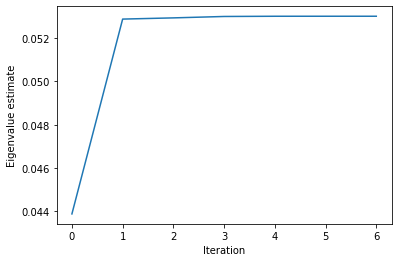

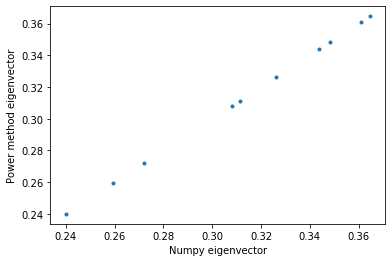

In [57]:
## Use the default eigensystem calculator in numpy as a point of comparison
def eigmax_numpy(A):
    """
    Compute the maximum eigenvalue and associated eigenvector in a matrix with Numpy.
    """
    eigsys = np.linalg.eig(A)
    ind = np.abs(eigsys[0]).argmax()
    return np.real(eigsys[0][ind]), np.real(eigsys[1][:, ind])
    
#  If I sample my matrices from a normal distribution these matrices fail to converge
mm = np.random.random(size=(10, 10)) / 100
model = SpectralDecompositionPowerMethod(store_intermediate_results=True,gamma=0.01)
model.fit(mm);


print(f"Power method solution: {model.singular_values_}")
print(f"Numpy solution: {eigmax_numpy(mm)[0]}")

plt.figure()
plt.plot(model.stored_eigenvalues)
plt.xlabel("Iteration")
plt.ylabel("Eigenvalue estimate")

plt.figure()
plt.plot(eigmax_numpy(mm)[1], model.components_, '.')
plt.xlabel("Numpy eigenvector")
plt.ylabel("Power method eigenvector")

In [73]:
"""
2. The power method would fail to converge if the matrix were singular, 
    resulting in eigenvalues of zero, or if there was no dominant eigenvalue.
    The method would take a very long time if the starting vector only had
    a very tiny componenet along the direction of the eigenvector associated
    with the largest eigenvalue.
    
3. Power method exhibits overdamped oscillatory behavior. The previosu cases would be 
    on a "flat" surface.
    
4. Momentum is implemented in the above code. It would help us avoid false minima

5. Damping would help us avoid underdamped oscillatory behavior of the algorithm.
"""

'\n2. The power method would fail to converge if the matrix were singular, \n    resulting in eigenvalues of zero, or if there was no dominant eigenvalue.\n    The method would take a very long time if the starting vector only had\n    a very tiny componenet along the direction of the eigenvector associated\n    with the largest eigenvalue.\n    \n3. Power method exhibits overdamped oscillatory behavior. The previosu cases would be \n    on a "flat" surface.\n    \n4. Momentum is implemented in the above code. It would help us avoid false minima\n\n5. Damping would help us avoid underdamped oscillatory behavior of the algorithm.\n'

In [5]:
Re = 1200 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"./resources/von_karman_street/vortex_street_velocities_Re_{Re}_largefile.npz", 
    allow_pickle=True
)
print("Velocity field data has shape: {}".format(vfield.shape))

# Calculate the vorticity, which is the curl of the velocity field
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0] 

Velocity field data has shape: (3000, 256, 128, 2)


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

# We are going to use class inheritance to define our object. The two base classes from
# scikit-learn represent placeholder objects for working with datasets. They include 
# many generic methods, like fetching parameters, getting the data shape, etc.
# 
# By inheriting from these classes, we ensure that our object will have access to these
# functions, even though we don't have to define them ourselves
class PrincipalComponents(BaseEstimator, TransformerMixin):
    """
    A class for performing principal component analysis on a dataset.
    """

    def __init__(self, random_state=None):
        self.random_state = random_state
        self.components_ = None
        self.singular_values_ = None

    def fit(self, X):
        """
        Fit the PCA model to the data X. Store the eigenvectors in the attribute
        self.components_ and the eigenvalues in the attribute self.singular_values_

        NOTE: This method needs to return self in order to work properly with the
         scikit-learn base classes from which it inherits.

        Args:
            X (np.ndarray): A 2D array of shape (n_samples, n_features) containing the
                data to be fit.
        
        Returns:
            self (PrincipalComponents): The fitted object.
        """
        
        X_cent = X - np.mean(X, axis=0)
        sigma = (1/X_cent.shape[0]) * np.dot(X_cent.T, X_cent)
        
        eValues, eVectors = np.linalg.eigh(sigma)

        idx = eValues.argsort()[::-1]   
        eValues = eValues[idx]
        eVectors = eVectors[:,idx]
        
        self.components_ = eVectors.T
        self.singular_values_ = eValues

        return self

        
    def transform(self, X):
        """
        Transform the data X into the new basis using the PCA components.

        Args:
            X (np.ndarray): A 2D array of shape (n_samples, n_features) containing the
                data to be transformed.

        Returns:
            X_new (np.ndarray): A 2D array of shape (n_samples, n_components) containing
                the transformed data. n_components <= n_features, depending on whether
                we truncated the eigensystem.
        """
        
        X_cent = X - np.mean(X, axis=0)
        return np.matmul(X_cent, self.components_.T)
        
        
    def inverse_transform(self, X):
        """
        Transform from principal components space back to the original space

        Args:
            X (np.ndarray): A 2D array of shape (n_samples, n_components) containing the
                data to be transformed. n_components <= n_features, depending on whether
                we truncated the eigensystem.

        Returns:
            X_new (np.ndarray): A 2D array of shape (n_samples, n_features) containing
                the transformed data.
        """
        
        return np.dot(X, self.components_) + np.mean(X, axis=0)

    ## You shouldn't need to implement this, because it gets inherited from the base
    ## class. But if you are having trouble with the inheritance, you can uncomment
    ## this and to implement it.
    # def fit_transform(self, X):
    #     self.fit(X)
    #     return self.transform(X)

Text(0, 0.5, 'Eigenvalue rank')

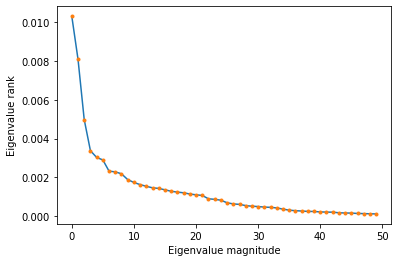

In [9]:

data = np.copy(vort_field)[::3, ::2, ::2] # subsample data to reduce compute load
data_reshaped = np.reshape(data, (data.shape[0], -1))

model = PrincipalComponents()
# model = PCA()

data_transformed = model.fit_transform(data_reshaped)
principal_components = np.reshape(
    model.components_, (model.components_.shape[0], data.shape[1], data.shape[2])
)

## Look at skree plot, and identify the "elbow" indicating low dimensionality
plt.figure()
plt.plot(model.singular_values_[:50])
plt.plot(model.singular_values_[:50], '.')
plt.xlabel("Eigenvalue magnitude")
plt.ylabel("Eigenvalue rank")

ValueError: Unknown projection '3d'

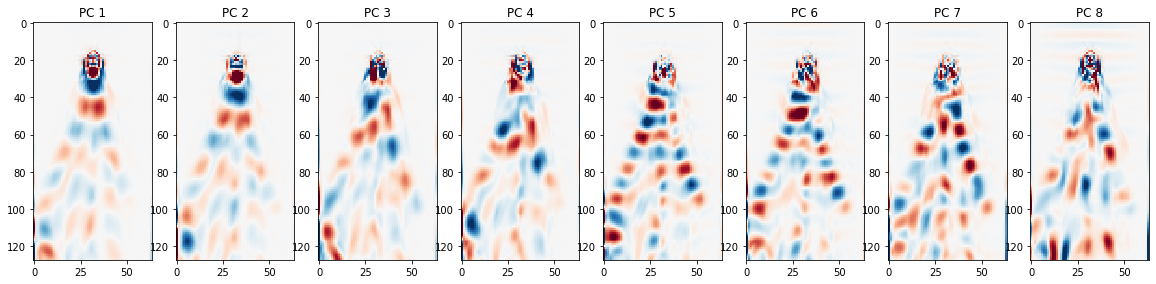

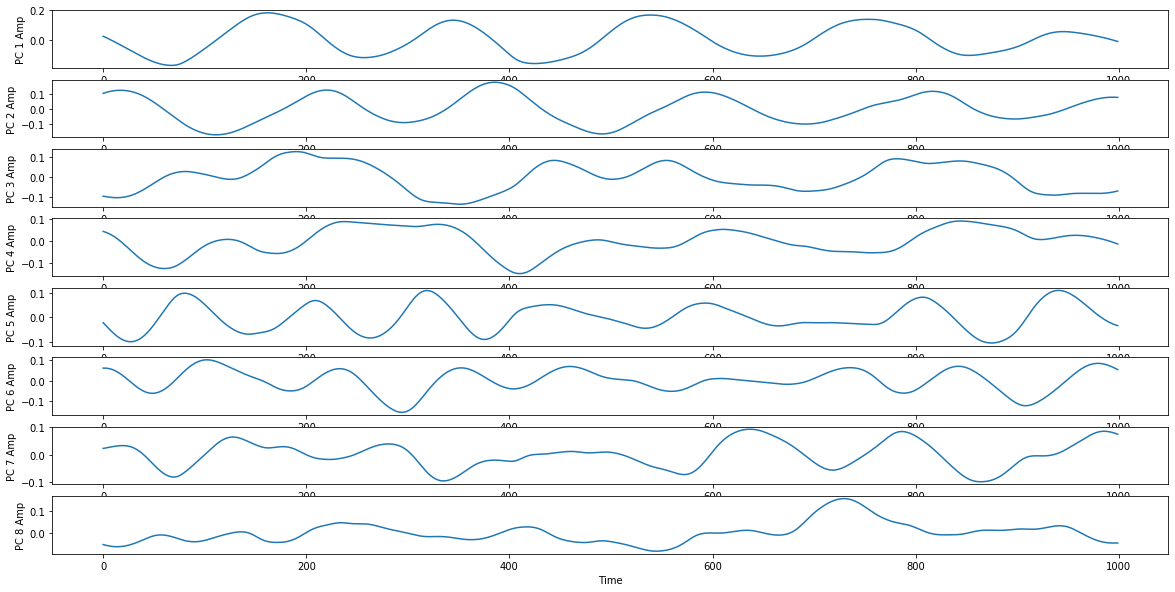

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    vscale = np.percentile(np.abs(principal_components[i]), 99)
    plt.imshow(principal_components[i], cmap="RdBu", vmin=-vscale, vmax=vscale)
    plt.title("PC {}".format(i+1))

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(data_transformed[:, i])
    plt.ylabel("PC {} Amp".format(i+1))
plt.xlabel("Time")

plt.figure()
ax = plt.axes(projection='3d')
ax.plot(data_transformed[:, 0], data_transformed[:, 1], data_transformed[:, 2])